In [1]:
# ✅ 初期化・必要ライブラリ
import pandas as pd
import numpy as np
from isodate import parse_duration
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from PIL import Image
import requests
from io import BytesIO
import cv2
import mediapipe as mp
from tqdm import tqdm

# ✅ サムネイル特徴量定義
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# ✅ サムネイル画像から特徴量を抽出（MediaPipe）
def extract_all_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=10)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        img_np = np.array(image)

        # 明度
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        brightness = hsv[:, :, 2].mean()

        # 色平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # カラークラスタ比率（KMeansで5色）
        pixels = img_np.reshape(-1, 3)
        pixels = np.float32(pixels)
        _, labels, centers = cv2.kmeans(pixels, 5, None,
                                        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                        10, cv2.KMEANS_RANDOM_CENTERS)
        color_ratios = [np.sum(labels.flatten() == i) / len(labels) for i in range(5)]

        # telop_ratio（文字領域）仮：白領域比率
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        telop_ratio = np.sum(thresh == 255) / thresh.size

        # 顔検出（MediaPipe）
        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            results = face_detection.process(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
            face_count = len(results.detections) if results.detections else 0

        return [
            brightness, face_count, telop_ratio,
            r_mean, g_mean, b_mean, h_mean, s_mean, v_mean
        ] + color_ratios

    except:
        return [0] * len(thumbnail_cols)

# ✅ データ読み込みと前処理（Shorts除外）
df = pd.read_excel("youtube_dataset_20250731.xlsx")
df["title"] = df["title"].fillna("")
df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(-1).astype(int)
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
df["publishedAt"] = pd.to_datetime(df["publishedAt"], utc=True)
df["duration_seconds"] = df["duration"].apply(lambda x: parse_duration(x).total_seconds() if pd.notnull(x) else 0)
df = df[df["duration_seconds"] > 60].copy()

# 🔍 サムネイル特徴量抽出（※すでにある場合はスキップ）
if not set(thumbnail_cols).issubset(df.columns):
    if "thumbnail" not in df.columns:
        raise ValueError("⚠️ 'thumbnail'列がデータに存在しません")
    features = []
    for url in tqdm(df["thumbnail"], desc="🔍 サムネイル特徴量抽出中"):
        features.append(extract_all_thumbnail_features_mediapipe(url))
    thumbnail_df = pd.DataFrame(features, columns=thumbnail_cols)
    df = pd.concat([df.reset_index(drop=True), thumbnail_df], axis=1)

# 🕒 投稿時間特徴量
df["weekday"] = df["publishedAt"].dt.weekday
df["hour"] = df["publishedAt"].dt.hour
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["is_month_start"] = df["publishedAt"].dt.is_month_start.astype(int)
df["is_month_end"] = df["publishedAt"].dt.is_month_end.astype(int)

# ✅ 特徴量定義
feature_cols = [
    "categoryId", "weekday", "hour", "is_weekend", "is_month_start", "is_month_end"
] + thumbnail_cols

# ✅ TF-IDF（タイトル）ベクトル化
tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)

# ✅ データ分割（6月以前を学習用に）
cutoff = pd.to_datetime("2025-07-01", utc=True)
df_train = df[df["publishedAt"] < cutoff].copy()

# TF-IDF変換
tfidf_train = vectorizer.fit_transform(df_train["title"])
tfidf_df_train = pd.DataFrame(tfidf_train.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df_train.index = df_train.index

# 特徴量統合
X_train = pd.concat([df_train[feature_cols].reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
y_train = np.log1p(df_train["viewCount"])

# ✅ モデル学習（RandomForest）
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("✅ 学習完了！（以降：予測用コードへ続く）")


🔍 サムネイル特徴量抽出中: 100%|█████████████████████████████████████████████████████| 951/951 [33:55<00:00,  2.14s/it]


✅ 学習完了！（以降：予測用コードへ続く）


In [2]:
# ✅ Phase 5: テストデータで予測（7月以降の動画）
df_test = df[df["publishedAt"] >= cutoff].copy()

# TF-IDF変換（学習済みvectorizerを使う）
tfidf_test = vectorizer.transform(df_test["title"])
tfidf_df_test = pd.DataFrame(tfidf_test.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df_test.index = df_test.index

# 特徴量結合
X_test = pd.concat([df_test[feature_cols].reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)
y_test = df_test["viewCount"]

# モデル予測（log → 実数）
log_preds = model.predict(X_test)
view_preds = np.expm1(log_preds).astype(int)

# ✅ Phase 6: 結果比較（表形式）
df_result = df_test[["title", "publishedAt", "viewCount"]].copy()
df_result["predicted_viewCount"] = view_preds
df_result["abs_error"] = (df_result["predicted_viewCount"] - df_result["viewCount"]).abs()
df_result = df_result.sort_values("publishedAt", ascending=False).reset_index(drop=True)

print("🎯 最新動画の予測結果（上位10件）:")
print(df_result.head(10))

# ✅ Phase 7: モデル評価（RMSEと特徴量の重要度可視化）
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

rmse_log = mean_squared_error(np.log1p(y_test), log_preds, squared=False)
print(f"📉 RMSE（logスケール）: {rmse_log:.4f}")

# 重要な特徴量の可視化
importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()



🎯 最新動画の予測結果（上位10件）:
                                               title  \
0  【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...   
1                        遂に決着がついてしまった件について。【真夏の喧嘩祭り】   
2                           コムドットの漫才が酷すぎると話題なので見てみた。   
3                       YouTube界に『歌ってみた』が帰ってきた件について。   
4                           啓之輔選手から本当にDM来てしまった件について。   
5                     ジュンの格闘技イキリが啓之輔選手に届いてしまった件について。   
6               【リボーンりょうすけが個人チャンネル開設】脱退の一途なのか？分析します。   
7                     リボーンが登録者購入疑惑で炎上している件について分析します。   
8  【アマリザのブレイキングダウン結果速報/ぷろたん&Rちゃん炎上/水溜まりボンドトミー炎上】漢だよ。   
9                        裏方の石田が人生で一度も破産したことがない件について。   

                publishedAt  viewCount  predicted_viewCount  abs_error  
0 2025-07-29 12:01:49+00:00     312205                74239     237966  
1 2025-07-27 12:01:40+00:00     351693               281908      69785  
2 2025-07-26 12:01:52+00:00     571930                37528     534402  
3 2025-07-23 12:01:59+00:00     320886               246058      74828 

TypeError: got an unexpected keyword argument 'squared'

📉 RMSE（logスケール）: 1.0074


C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 12366 (\N{HIRAGANA LETTER GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 24112 (\N{CJK UNIFIED IDEOGRAPH-5E30}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 23429 (\N{CJK UNIFIED IDEOGRAPH-5B85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_22812\754988640.py:18: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing 

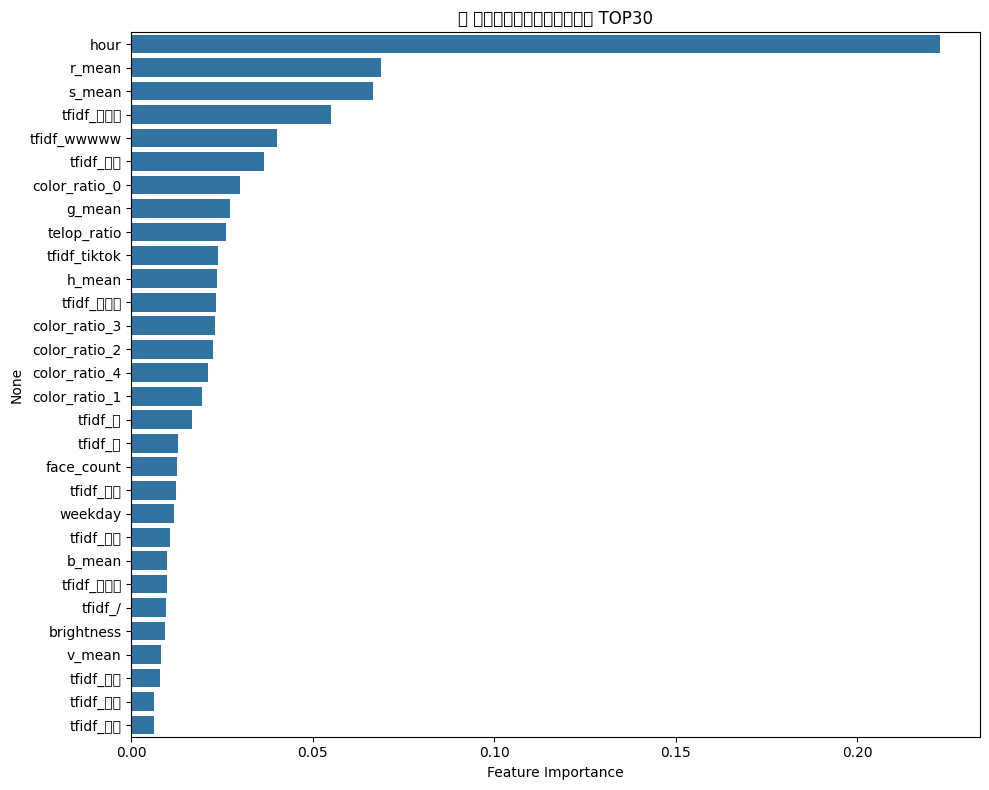

In [3]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ RMSE（scikit-learnが古い場合の対策込み）
mse_log = mean_squared_error(np.log1p(y_test), log_preds)
rmse_log = np.sqrt(mse_log)
print(f"📉 RMSE（logスケール）: {rmse_log:.4f}")

# ✅ 特徴量重要度の可視化
importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


In [4]:
# ✅ df_test（予測対象）の動画タイトルと顔の数を確認する表
face_count_df = df_test[["title", "face_count"]].copy()

# 顔の数が多い順に並べる（任意）
face_count_df = face_count_df.sort_values("face_count", ascending=False).reset_index(drop=True)

# 表示（Jupyter上で見やすく）
from IPython.display import display
display(face_count_df.head(20))  # 先頭20件だけ表示（調整可能）


,title,face_count
0,【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...,5
1,【シルクがステゴロパンチャーズについて言及/フィッシャーズがファンアートの募集4年間放置し謝...,5
2,リボーンが登録者購入疑惑で炎上している件について分析します。,4
3,【アマリザのブレイキングダウン結果速報/ぷろたん&Rちゃん炎上/水溜まりボンドトミー炎上】漢だよ。,3
4,遂に決着がついてしまった件について。【真夏の喧嘩祭り】,2
5,コムドットの漫才が酷すぎると話題なので見てみた。,2
6,【リボーンりょうすけが個人チャンネル開設】脱退の一途なのか？分析します。,2
7,久々にあきらくんを覗いたらとんでもない事を成し遂げていた。,2
8,かけまるのなーちゃんが彼氏と喧嘩している件について【ステパン恋愛相談窓口vol.1】,2
9,中町JP「僕はコンプレックスを気にしすぎてしまう病気なんです」→「同じ悩みを持つ方の為に美容...,2
